### Credit card approvals dataset classification models

In [132]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics
from sklearn . metrics import confusion_matrix

#### Import and clean up

In [200]:
df = pd.read_csv('cc_approvals.csv')

In [201]:
# add column names to dataframe
df.columns = ['gender', 'age', 'debt', 'married', 'bankcustomer', 'educationlevel',
       'ethnicity', 'yearsemployed', 'priordefault', 'employed', 'creditscore',
       'driverslicense', 'citizen', 'zipcode', 'income', 'approvalstatus']

In [202]:
df.head()

gender    age   debt married bankcustomer educationlevel ethnicity  \
0      a  58.67  4.460       u            g              q         h   
1      a  24.50  0.500       u            g              q         h   
2      b  27.83  1.540       u            g              w         v   
3      b  20.17  5.625       u            g              w         v   
4      b  32.08  4.000       u            g              m         v   

   yearsemployed priordefault employed  creditscore driverslicense citizen  \
0           3.04            t        t            6              f       g   
1           1.50            t        f            0              f       g   
2           3.75            t        t            5              t       g   
3           1.71            t        f            0              f       s   
4           2.50            t        f            0              t       g   

  zipcode  income approvalstatus  
0   00043     560              +  
1   00280     824              +  
2   00100       3              +  
3   00120       0              +  
4   00360       0              +

In [31]:
df.shape

(689, 16)

In [6]:
# check for null values
df.columns.isnull()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [203]:
# replace problem characters with integers
df.approvalstatus = df.approvalstatus.replace('+', 1)
df.approvalstatus = df.approvalstatus.replace('-', 0)
df = df.replace('?',0 )

In [186]:
df.dtypes

gender             object
age                object
debt              float64
married            object
bankcustomer       object
educationlevel     object
ethnicity          object
yearsemployed     float64
priordefault       object
employed           object
creditscore         int64
driverslicense     object
citizen            object
zipcode            object
income              int64
approvalstatus      int64
dtype: object

In [204]:
df["age"] = pd.to_numeric(df["age"])
df["zipcode"] = pd.to_numeric(df["zipcode"])

Text(0.5, 1.0, 'Credit card approvals')

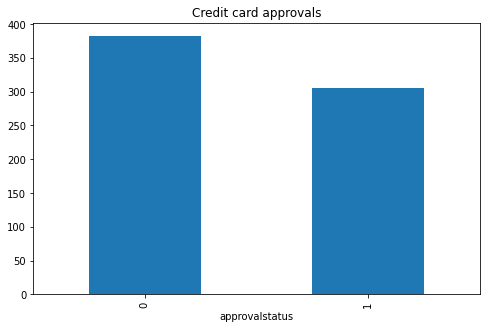

In [10]:
# plot to show distribution
data = df['approvalstatus'].value_counts()
data.plot(kind='bar',figsize=(8,5))
plt.title('Credit card approvals')

In [205]:
# Split the dataset

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=2)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=2)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [206]:
len(df_full_train), len(df_test), len(df_train), len(df_val)

(551, 138, 413, 138)

In [121]:
numerical = ['age', 'debt', 'yearsemployed', 'income', 'zipcode','creditscore']
categorical = ['gender', 'married', 'bankcustomer', 'educationlevel',
       'ethnicity', 'priordefault', 'employed', 'driverslicense', 'citizen', 'approvalstatus']

In [131]:
# find unique values

for i in categorical:
    print(i + '   ' +str(df_train[i].unique()))

gender   ['a' 'b' 0]
married   ['u' 'y' 0 'l']
bankcustomer   ['g' 'p' 0 'gg']
educationlevel   ['j' 'ff' 'q' 'cc' 'x' 'c' 'w' 'i' 'm' 'aa' 'k' 0 'd' 'e' 'r']
ethnicity   ['j' 'ff' 'v' 'h' 'bb' 0 'dd' 'z' 'o' 'n']
priordefault   ['f' 't']
employed   ['t' 'f']
driverslicense   ['f' 't']
citizen   ['g' 's' 'p']
approvalstatus   [0 1]


In [196]:
# find max and min values for numerical columns

for c in numerical:
    print(c, df[c].max(), df[c].min())

age 80.25 0.0
debt 28.0 0.0
yearsemployed 28.5 0.0
zipcode 2000 0
income 100000 0
creditscore 67 0


In [125]:
# find correlations in the data with correlation matrix without target
df_num = df_train[numerical]
matrix = df_num.corr()
matrix

age      debt  yearsemployed   zipcode    income  \
age            1.000000  0.156966       0.325579 -0.050554  0.098186   
debt           0.156966  1.000000       0.262488 -0.253083  0.049651   
yearsemployed  0.325579  0.262488       1.000000 -0.012405  0.110212   
zipcode       -0.050554 -0.253083      -0.012405  1.000000  0.057450   
income         0.098186  0.049651       0.110212  0.057450  1.000000   
creditscore    0.186689  0.303799       0.301280 -0.080070  0.102318   

               creditscore  
age               0.186689  
debt              0.303799  
yearsemployed     0.301280  
zipcode          -0.080070  
income            0.102318  
creditscore       1.000000

In [130]:
# test feature importance with auc

for c in numerical:
    print(c + '   ' + str(roc_auc_score(df_train.approvalstatus, df_train[c])).rjust(40 - len(c)))

age                      0.6395051398517811
debt                     0.6186947167104948
yearsemployed            0.7305163758068371
zipcode                  0.4380588094668898
income                   0.6874252928520201
creditscore              0.7632560363375568


#### Train Logistic Regression and validate model

- prepare x and y data
- transform lists of feature-value mappings to vectors using DictVectorizer
- train logistic regression model
- validate data with X_val
- calculate accuracy scores, copy results data to dataframe

In [207]:
# prepare x and y data
 
target = 'approvalstatus'
y_full_train = df_full_train[target]
y_test = df_test[target]
y_train = df_train[target]
y_val = df_val[target]

del df_test[target]
del df_train[target]
del df_val[target]

# model is more accurate with ethicity removed
delete = 'ethnicity'
del df_test[delete]
del df_train[delete]
del df_val[delete]



In [255]:
del df_full_train[target]
del df_full_train[delete]



In [208]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)


In [209]:

model = LogisticRegression(solver='liblinear', C=1, max_iter=1000, random_state=2)
model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=2, solver='liblinear')

In [210]:
# calculate accuracy
y_pred = model.predict_proba(X_val)[:,1]
y_pred_bool = (y_pred >= 0.5).astype(int)
(y_val == y_pred_bool).mean()

0.8478260869565217

In [211]:
df_pred = pd.DataFrame()
df_pred['actual'] = y_val
df_pred['probability'] = y_pred
df_pred['prediction'] = y_pred_bool.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred.correct.mean().round(4)

0.8478

#### Model Evaluation

- AUC
- Confusion Matrix
- thresholds
- f-score
- kfold to refine c

In [212]:
# calculate roc auc score

lr_val_auc = roc_auc_score(y_val,y_pred_bool)
lr_val_auc

0.8449010006387055

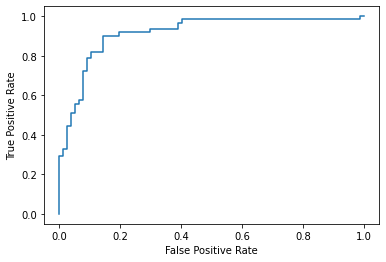

In [213]:
# plot ROC curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [214]:
# calculate confusion matrix to show true and false classifications
lr_cm = confusion_matrix (y_val , y_pred_bool )
lr_cm

array([[67, 10],
       [11, 50]], dtype=int64)

Text(0.5, 24.0, 'Predicted label')

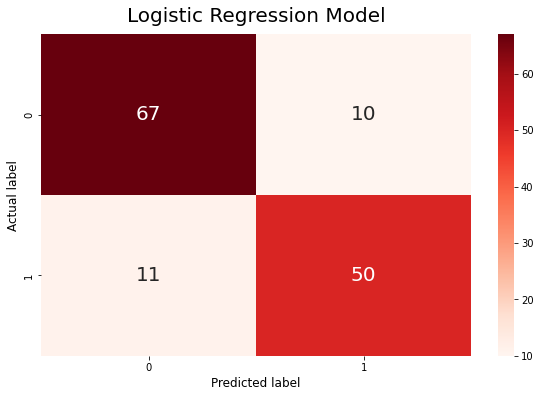

In [215]:
# clear labelled version using seaborn heatmap

class_names =[0 ,1]
fig , ax = plt. subplots (figsize=(8,5))
tick_marks = np. arange (len( class_names ))
plt. xticks ( tick_marks, class_names)
plt. yticks ( tick_marks , class_names )
sns. heatmap (pd. DataFrame (lr_cm), annot = True ,cmap = "Reds" ,
              fmt="2g", xticklabels = (0, 1), yticklabels = (0, 1), 
              annot_kws={'size': 20, 'rotation': 0})
ax. xaxis . set_label_position ("bottom")
plt. tight_layout ()
plt. title ("Logistic Regression Model", y =1.02, fontsize=20)
plt. ylabel ("Actual label", fontsize=12)
plt. xlabel ("Predicted label", fontsize=12)

In [216]:
thresholds = np.arange(0, 1.0, 0.01)
prec = []
rec = []
for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    prec.append(p)
    rec.append(r)

columns = [ 'thresholds','prec', 'rec']
scores = [thresholds, prec, rec]
#df['column_name']=pd.Series(arr)
df_scores = pd.DataFrame(scores, columns)
df_scores = df_scores.T
df_scores

thresholds      prec       rec
0         0.00  0.442029  1.000000
1         0.01  0.441176  0.983607
2         0.02  0.458015  0.983607
3         0.03  0.500000  0.983607
4         0.04  0.512821  0.983607
..         ...       ...       ...
95        0.95  1.000000  0.262295
96        0.96  1.000000  0.262295
97        0.97  1.000000  0.229508
98        0.98  1.000000  0.180328
99        0.99  1.000000  0.131148

[100 rows x 3 columns]

In [217]:
df_scores[40:50]

thresholds      prec       rec
40        0.40  0.830769  0.885246
41        0.41  0.830769  0.885246
42        0.42  0.830769  0.885246
43        0.43  0.819672  0.819672
44        0.44  0.819672  0.819672
45        0.45  0.819672  0.819672
46        0.46  0.819672  0.819672
47        0.47  0.819672  0.819672
48        0.48  0.833333  0.819672
49        0.49  0.833333  0.819672

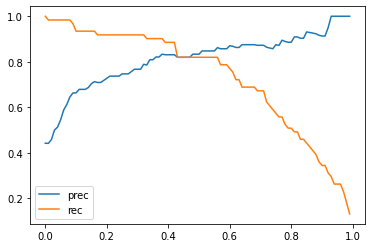

In [218]:
plt.plot(df_scores.thresholds, df_scores['prec'], label='prec')
plt.plot(df_scores.thresholds, df_scores['rec'], label='rec')
plt.legend()

In [219]:
def f1_score(p,r):
    a = p*r
    b = p+r
    c = a/b
    f1 = 2*c
    return f1

In [220]:
df_scores['f1_score'] = df_scores.apply(lambda x: f1_score(x['prec'],x['rec']), axis = 1)
df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()]

thresholds      prec       rec  f1_score
38        0.38  0.833333  0.901639  0.866142

In [221]:
def train(df_train, y_train, C=1.0):

    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver = 'liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [222]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [223]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.3, 0.4, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_tr = df_full_train.iloc[train_idx]
        df_vl = df_full_train.iloc[val_idx]

        y_tr = df_tr.approvalstatus.values
        y_vl = df_vl.approvalstatus.values

        dv, model = train(df_tr, y_tr, C=C)
        y_pred = predict(df_vl, dv, model)

        auc = roc_auc_score(y_vl, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/8 [00:00<?, ?it/s]

C=0.01 0.944 +- 0.025
C=0.1 0.997 +- 0.003
C=0.3 1.000 +- 0.000
C=0.4 1.000 +- 0.000
C=0.5 1.000 +- 0.000
C=1 1.000 +- 0.000
C=5 1.000 +- 0.000
C=10 1.000 +- 0.000


#### Retrain model with refined parameters
- C is left at 1
- thrshold changed to 0.38

In [224]:
model = LogisticRegression(solver='liblinear', C=1, max_iter=1000, random_state=2)
model.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=2, solver='liblinear')

In [227]:
# calculate accuracy
y_pred = model.predict_proba(X_val)[:,1]
y_pred_bool = (y_pred >= 0.38).astype(int)
(y_val == y_pred_bool).mean()

0.8768115942028986

In [226]:
# calculate roc auc score

lr_val_auc = roc_auc_score(y_val,y_pred_bool)
lr_val_auc

0.8449010006387055

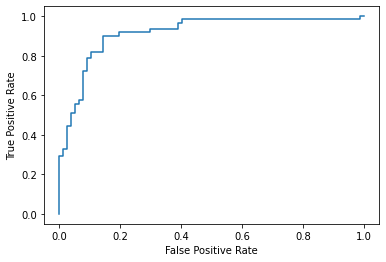

In [228]:
# plot ROC curve

fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Tree-based Models - RF and XGBoost

In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
import xgboost as xgb

In [230]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.fillna(0).to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [231]:
rf = RandomForestClassifier(max_depth = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [232]:
y_pred = rf.predict(X_val)
roc_auc_score(y_val, y_pred)


0.8677879497551628

In [233]:
rf_cm = confusion_matrix (y_val , y_pred )
rf_cm

array([[68,  9],
       [ 9, 52]], dtype=int64)

Text(0.5, 24.0, 'Predicted label')

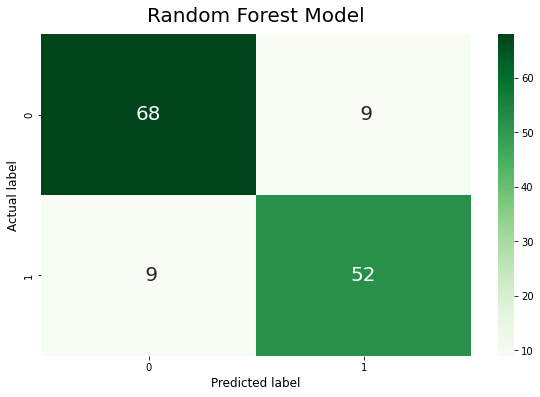

In [234]:
# clear labelled version using seaborn heatmap

class_names =[0 ,1]
fig , ax = plt. subplots (figsize=(8,5))
tick_marks = np. arange (len( class_names ))
plt. xticks ( tick_marks, class_names)
plt. yticks ( tick_marks , class_names )
sns. heatmap (pd. DataFrame (rf_cm), annot = True ,cmap = "Greens" ,
              fmt="2g", xticklabels = (0, 1), yticklabels = (0, 1), 
              annot_kws={'size': 20, 'rotation': 0})
ax. xaxis . set_label_position ("bottom")
plt. tight_layout ()
plt. title ("Random Forest Model", y =1.02, fontsize=20)
plt. ylabel ("Actual label", fontsize=12)
plt. xlabel ("Predicted label", fontsize=12)

##### Test different parameters - RF
- number of estimators
- depth of tree

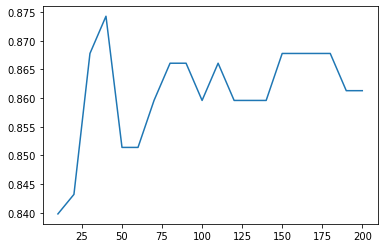

In [235]:
# test number of estimators - how many trees make a forest?

scores = []

for n in range (10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)  
    scores.append((n, roc_auc_score(y_val, y_pred)))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'roc_auc_score'])
plt.plot(df_scores.n_estimators, df_scores.roc_auc_score)    

In [236]:
# estimators and depth of tree

values = [10, 15, 20, 25]
scores = []
for v in values:
    for n in range (10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1, max_depth = v)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)  
        scores.append((v, n, roc_auc_score(y_val, y_pred)))
        
df_depth_scores = pd.DataFrame(scores, columns = ['depth', 'estimators', 'roc_auc_score'] )        

In [239]:
df_depth_scores.roc_auc_score.max()

0.8742814562486693

In [240]:
df_depth_scores[df_depth_scores['roc_auc_score'] == df_depth_scores.roc_auc_score.max()]

depth  estimators  roc_auc_score
23     15          40       0.874281
43     20          40       0.874281
63     25          40       0.874281

#### Use parameters from tests to train improved model


In [241]:
rf = RandomForestClassifier(n_estimators=40, random_state=1, n_jobs=-1, max_depth = 15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)  

roc_auc_score(y_val, y_pred)

0.8742814562486693

#### Train XGBoost
- train first version
- tune eta parameter
- tune eta, max_depth and min_child_weight together

In [242]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [243]:
# first version
watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred )

[0]	train-rmse:0.38482	val-rmse:0.41919
[1]	train-rmse:0.30883	val-rmse:0.38500
[2]	train-rmse:0.25509	val-rmse:0.36155
[3]	train-rmse:0.21762	val-rmse:0.36227
[4]	train-rmse:0.18408	val-rmse:0.36013
[5]	train-rmse:0.15868	val-rmse:0.36217
[6]	train-rmse:0.14080	val-rmse:0.36282
[7]	train-rmse:0.12654	val-rmse:0.35803
[8]	train-rmse:0.11905	val-rmse:0.35670
[9]	train-rmse:0.11207	val-rmse:0.35653
[10]	train-rmse:0.10634	val-rmse:0.35556
[11]	train-rmse:0.10293	val-rmse:0.35530
[12]	train-rmse:0.10008	val-rmse:0.35393
[13]	train-rmse:0.08967	val-rmse:0.35569
[14]	train-rmse:0.08430	val-rmse:0.35597
[15]	train-rmse:0.07910	val-rmse:0.35693
[16]	train-rmse:0.07312	val-rmse:0.35869
[17]	train-rmse:0.07205	val-rmse:0.35914
[18]	train-rmse:0.06527	val-rmse:0.36220
[19]	train-rmse:0.06064	val-rmse:0.36304
[20]	train-rmse:0.05532	val-rmse:0.36388
[21]	train-rmse:0.05193	val-rmse:0.36519
[22]	train-rmse:0.04990	val-rmse:0.36620
[23]	train-rmse:0.04600	val-rmse:0.36734
[24]	train-rmse:0.04434	va

0.8852459016393442

In [244]:
y_pred_bool = (y_pred >= 0.5).astype(int)
xgb_cm = confusion_matrix (y_val , y_pred_bool)
xgb_cm

array([[65, 12],
       [15, 46]], dtype=int64)

In [245]:
#train etas
watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
scores = []
etas = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]
for i in etas:
    xgb_params = {
        'eta': i, 
        'max_depth': 6,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

    y_pred = model.predict(dval)
    scores.append((i, roc_auc_score(y_val, y_pred )))

[0]	train-rmse:0.45743	val-rmse:0.46857
[1]	train-rmse:0.42359	val-rmse:0.44566
[2]	train-rmse:0.39317	val-rmse:0.42847
[3]	train-rmse:0.36617	val-rmse:0.41474
[4]	train-rmse:0.34248	val-rmse:0.40302
[5]	train-rmse:0.32114	val-rmse:0.39321
[6]	train-rmse:0.30173	val-rmse:0.38603
[7]	train-rmse:0.28260	val-rmse:0.37994
[8]	train-rmse:0.26765	val-rmse:0.37704
[9]	train-rmse:0.25201	val-rmse:0.37267
[10]	train-rmse:0.23838	val-rmse:0.36978
[11]	train-rmse:0.22589	val-rmse:0.36999
[12]	train-rmse:0.21399	val-rmse:0.36787
[13]	train-rmse:0.20437	val-rmse:0.36620
[14]	train-rmse:0.19469	val-rmse:0.36620
[15]	train-rmse:0.18593	val-rmse:0.36609
[16]	train-rmse:0.17623	val-rmse:0.36521
[17]	train-rmse:0.16955	val-rmse:0.36797
[18]	train-rmse:0.16169	val-rmse:0.36746
[19]	train-rmse:0.15571	val-rmse:0.36654
[20]	train-rmse:0.14968	val-rmse:0.36578
[21]	train-rmse:0.14515	val-rmse:0.36581
[22]	train-rmse:0.14132	val-rmse:0.36462
[23]	train-rmse:0.13707	val-rmse:0.36475
[24]	train-rmse:0.13353	va

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[36]	train-rmse:0.10718	val-rmse:0.36285
[37]	train-rmse:0.10380	val-rmse:0.36317
[38]	train-rmse:0.10059	val-rmse:0.36281
[39]	train-rmse:0.09918	val-rmse:0.36263
[40]	train-rmse:0.09659	val-rmse:0.36303
[41]	train-rmse:0.09393	val-rmse:0.36312
[42]	train-rmse:0.09328	val-rmse:0.36274
[43]	train-rmse:0.09106	val-rmse:0.36279
[44]	train-rmse:0.08848	val-rmse:0.36286
[45]	train-rmse:0.08786	val-rmse:0.36250
[46]	train-rmse:0.08744	val-rmse:0.36206
[47]	train-rmse:0.08562	val-rmse:0.36225
[48]	train-rmse:0.08368	val-rmse:0.36285
[49]	train-rmse:0.08260	val-rmse:0.36320
[50]	train-rmse:0.08132	val-rmse:0.36337
[51]	train-rmse:0.07957	val-rmse:0.36364
[52]	train-rmse:0.07844	val-rmse:0.36383
[53]	train-rmse:0.07683	val-rmse:0.36376
[54]	train-rmse:0.07537	val-rmse:0.36341
[55]	train-rmse:0.07438	val-rmse:0.36360
[56]	train-rmse:0.07364	val-rmse:0.36379
[57]	train-rmse:0.07283	val-rmse:0.36370
[58]	train-rmse:0.07106	val-rmse:0.36321
[59]	train-rmse:0.06933	val-rmse:0.36347
[60]	train-rmse:

In [246]:
scores

[(0.1, 0.8782201405152226),
 (0.3, 0.8852459016393442),
 (0.5, 0.9022780498190335),
 (0.7, 0.8973813072173727),
 (1, 0.8901426442410049),
 (1.5, 0.8413881200766447),
 (2, 0.7535661060251224)]

In [249]:
# this cell takes about 5 minutes to run
# train parameters


watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
scores = []
max_depths = [1, 3, 5, 10, 15, 20, 25, 50]
etas = [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2]
min_child_weights = [1, 3, 5, 10, 15, 20, 25, 50]

for e in etas:
    for m in max_depths:
        for i in min_child_weights:
            xgb_params = {
                'eta': 0.1, 
                'max_depth': i,
                'min_child_weight': 1,
                'objective': 'reg:squarederror',
                'nthread': 8,
                'seed': 1,
                'verbosity': 1,
            }

            model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

            y_pred = model.predict(dval)
            scores.append((e, m, i, roc_auc_score(y_val, y_pred )))

[0]	train-rmse:0.47108	val-rmse:0.47270
[1]	train-rmse:0.45055	val-rmse:0.45227
[2]	train-rmse:0.43320	val-rmse:0.43500
[3]	train-rmse:0.41860	val-rmse:0.42048
[4]	train-rmse:0.40638	val-rmse:0.40834
[5]	train-rmse:0.39619	val-rmse:0.39822
[6]	train-rmse:0.38773	val-rmse:0.38983
[7]	train-rmse:0.38074	val-rmse:0.38290
[8]	train-rmse:0.37496	val-rmse:0.37804
[9]	train-rmse:0.36966	val-rmse:0.37270
[10]	train-rmse:0.36531	val-rmse:0.36831
[11]	train-rmse:0.36134	val-rmse:0.36486
[12]	train-rmse:0.35785	val-rmse:0.36278
[13]	train-rmse:0.35481	val-rmse:0.35960
[14]	train-rmse:0.35197	val-rmse:0.35761
[15]	train-rmse:0.34939	val-rmse:0.35615
[16]	train-rmse:0.34701	val-rmse:0.35396
[17]	train-rmse:0.34490	val-rmse:0.35255
[18]	train-rmse:0.34301	val-rmse:0.35114
[19]	train-rmse:0.34130	val-rmse:0.34886
[20]	train-rmse:0.33973	val-rmse:0.34787
[21]	train-rmse:0.33830	val-rmse:0.34618
[22]	train-rmse:0.33698	val-rmse:0.34567
[23]	train-rmse:0.33566	val-rmse:0.34501
[24]	train-rmse:0.33446	va

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[54]	train-rmse:0.31310	val-rmse:0.33585
[55]	train-rmse:0.31268	val-rmse:0.33587
[56]	train-rmse:0.31227	val-rmse:0.33545
[57]	train-rmse:0.31186	val-rmse:0.33537
[58]	train-rmse:0.31147	val-rmse:0.33519
[59]	train-rmse:0.31110	val-rmse:0.33518
[60]	train-rmse:0.31072	val-rmse:0.33493
[61]	train-rmse:0.31035	val-rmse:0.33481
[62]	train-rmse:0.30999	val-rmse:0.33504
[63]	train-rmse:0.30963	val-rmse:0.33453
[64]	train-rmse:0.30928	val-rmse:0.33422
[65]	train-rmse:0.30894	val-rmse:0.33510
[66]	train-rmse:0.30861	val-rmse:0.33506
[67]	train-rmse:0.30829	val-rmse:0.33496
[68]	train-rmse:0.30797	val-rmse:0.33469
[69]	train-rmse:0.30766	val-rmse:0.33449
[70]	train-rmse:0.30737	val-rmse:0.33459
[71]	train-rmse:0.30707	val-rmse:0.33423
[72]	train-rmse:0.30677	val-rmse:0.33445
[73]	train-rmse:0.30650	val-rmse:0.33442
[74]	train-rmse:0.30622	val-rmse:0.33464
[75]	train-rmse:0.30594	val-rmse:0.33440
[76]	train-rmse:0.30567	val-rmse:0.33432
[77]	train-rmse:0.30541	val-rmse:0.33368
[78]	train-rmse:

In [250]:
# turn scores into df
df_xgb_parameters = pd.DataFrame(scores, columns = ['eta', 'max_depth', 'min_child_weight','roc_auc_score'] )        

In [251]:
df_xgb_parameters[df_xgb_parameters['roc_auc_score']==df_xgb_parameters['roc_auc_score'].max()]

eta  max_depth  min_child_weight  roc_auc_score
0    0.1          1                 1       0.922717
8    0.1          3                 1       0.922717
16   0.1          5                 1       0.922717
24   0.1         10                 1       0.922717
32   0.1         15                 1       0.922717
40   0.1         20                 1       0.922717
48   0.1         25                 1       0.922717
56   0.1         50                 1       0.922717
64   0.3          1                 1       0.922717
72   0.3          3                 1       0.922717
80   0.3          5                 1       0.922717
88   0.3         10                 1       0.922717
96   0.3         15                 1       0.922717
104  0.3         20                 1       0.922717
112  0.3         25                 1       0.922717
120  0.3         50                 1       0.922717
128  0.5          1                 1       0.922717
136  0.5          3                 1       0.922717
144  0.5          5                 1       0.922717
152  0.5         10                 1       0.922717
160  0.5         15                 1       0.922717
168  0.5         20                 1       0.922717
176  0.5         25                 1       0.922717
184  0.5         50                 1       0.922717
192  0.7          1                 1       0.922717
200  0.7          3                 1       0.922717
208  0.7          5                 1       0.922717
216  0.7         10                 1       0.922717
224  0.7         15                 1       0.922717
232  0.7         20                 1       0.922717
240  0.7         25                 1       0.922717
248  0.7         50                 1       0.922717
256  1.0          1                 1       0.922717
264  1.0          3                 1       0.922717
272  1.0          5                 1       0.922717
280  1.0         10                 1       0.922717
288  1.0         15                 1       0.922717
296  1.0         20                 1       0.922717
304  1.0         25                 1       0.922717
312  1.0         50                 1       0.922717
320  1.5          1                 1       0.922717
328  1.5          3                 1       0.922717
336  1.5          5                 1       0.922717
344  1.5         10                 1       0.922717
352  1.5         15                 1       0.922717
360  1.5         20                 1       0.922717
368  1.5         25                 1       0.922717
376  1.5         50                 1       0.922717
384  2.0          1                 1       0.922717
392  2.0          3                 1       0.922717
400  2.0          5                 1       0.922717
408  2.0         10                 1       0.922717
416  2.0         15                 1       0.922717
424  2.0         20                 1       0.922717
432  2.0         25                 1       0.922717
440  2.0         50                 1       0.922717

#### Use tuned parameters to train improved model

In [252]:
# use parameters from test 
watchlist = [(dtrain, 'train'), (dval, 'val')]

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
xgb_params = {
        'eta': 0.1, 
        'max_depth': 1,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred )

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


0.9227166276346603

#### Train best model - XGB with tuned parameters - on full dataset

In [256]:
# train best model on full train data
#del df_full_train['approvalstatus']
dv = DictVectorizer(sparse=False)
full_train_dicts = df_full_train.fillna(0).to_dict(orient='records')
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts = df_test.fillna(0).to_dict(orient='records')
X_test = dv.transform(test_dicts)

watchlist = [(dtrain, 'train'), (dval, 'val')]

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_test, label=y_test)
xgb_params = {
        'eta': 0.1, 
        'max_depth': 1,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

model = xgb.train(xgb_params, dfulltrain, num_boost_round=200, evals=watchlist)

y_pred = model.predict(dtest)
roc_auc_score(y_test, y_pred )

[0]	train-rmse:0.47106	val-rmse:0.47265
[1]	train-rmse:0.45053	val-rmse:0.45222
[2]	train-rmse:0.43317	val-rmse:0.43495
[3]	train-rmse:0.41857	val-rmse:0.42044
[4]	train-rmse:0.40634	val-rmse:0.40830
[5]	train-rmse:0.39616	val-rmse:0.39819
[6]	train-rmse:0.38770	val-rmse:0.38980
[7]	train-rmse:0.38071	val-rmse:0.38287
[8]	train-rmse:0.37475	val-rmse:0.37655
[9]	train-rmse:0.36950	val-rmse:0.37127
[10]	train-rmse:0.36508	val-rmse:0.36637
[11]	train-rmse:0.36118	val-rmse:0.36237
[12]	train-rmse:0.35793	val-rmse:0.35858
[13]	train-rmse:0.35504	val-rmse:0.35556
[14]	train-rmse:0.35227	val-rmse:0.35326
[15]	train-rmse:0.34989	val-rmse:0.35104
[16]	train-rmse:0.34758	val-rmse:0.34924
[17]	train-rmse:0.34557	val-rmse:0.34747
[18]	train-rmse:0.34379	val-rmse:0.34550
[19]	train-rmse:0.34200	val-rmse:0.34433
[20]	train-rmse:0.34046	val-rmse:0.34299
[21]	train-rmse:0.33926	val-rmse:0.34124
[22]	train-rmse:0.33793	val-rmse:0.34029
[23]	train-rmse:0.33688	val-rmse:0.33904
[24]	train-rmse:0.33557	va

c:\Users\rlong\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[31]	train-rmse:0.32860	val-rmse:0.33336
[32]	train-rmse:0.32781	val-rmse:0.33265
[33]	train-rmse:0.32694	val-rmse:0.33232
[34]	train-rmse:0.32611	val-rmse:0.33188
[35]	train-rmse:0.32539	val-rmse:0.33126
[36]	train-rmse:0.32464	val-rmse:0.33092
[37]	train-rmse:0.32391	val-rmse:0.33062
[38]	train-rmse:0.32326	val-rmse:0.33024
[39]	train-rmse:0.32256	val-rmse:0.32997
[40]	train-rmse:0.32205	val-rmse:0.32926
[41]	train-rmse:0.32149	val-rmse:0.32873
[42]	train-rmse:0.32083	val-rmse:0.32850
[43]	train-rmse:0.32037	val-rmse:0.32785
[44]	train-rmse:0.31979	val-rmse:0.32763
[45]	train-rmse:0.31928	val-rmse:0.32722
[46]	train-rmse:0.31875	val-rmse:0.32701
[47]	train-rmse:0.31830	val-rmse:0.32655
[48]	train-rmse:0.31776	val-rmse:0.32638
[49]	train-rmse:0.31739	val-rmse:0.32576
[50]	train-rmse:0.31699	val-rmse:0.32525
[51]	train-rmse:0.31649	val-rmse:0.32507
[52]	train-rmse:0.31617	val-rmse:0.32440
[53]	train-rmse:0.31577	val-rmse:0.32409
[54]	train-rmse:0.31532	val-rmse:0.32397
[55]	train-rmse:

0.9653142737019129

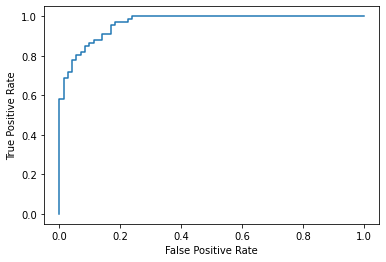

In [257]:
# roc auc curve for final model

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)

plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()